## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [335]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

In [336]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

# Set themes, styles and color palette for seaborn charts
sns.set_theme(style='darkgrid', context='poster')
sns.set_palette(palette='pastel', n_colors=10)

plt.rcParams["figure.figsize"] = (12, 4)
plt.rcParams["axes.titlesize"] = 14 
plt.rcParams["axes.labelsize"] = 12 
plt.rcParams["xtick.labelsize"] = 10 
plt.rcParams["ytick.labelsize"] = 10 

In [337]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=ImportWarning)
warnings.filterwarnings("ignore", category=Warning)

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [338]:
# Opening JSON file
with open('complaints-2021-05-14_08_16.json', 'r') as f: # Write the path to your data file and load it
    # returns JSON object as
    # a dictionary
    data = json.load(f)
    df=pd.json_normalize(data)

## Data preparation

In [339]:
# Inspect the dataframe to understand the given data.
print(df.shape)

(78313, 22)


In [340]:
df.head(2)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided


In [341]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [342]:
df.isnull().sum()

_index                                   0
_type                                    0
_id                                      0
_score                                   0
_source.tags                         67413
_source.zip_code                      6757
_source.complaint_id                     0
_source.issue                            0
_source.date_received                    0
_source.state                         1991
_source.consumer_disputed                0
_source.product                          0
_source.company_response                 0
_source.company                          0
_source.submitted_via                    0
_source.date_sent_to_company             0
_source.company_public_response      78309
_source.sub_product                  10571
_source.timely                           0
_source.complaint_what_happened          0
_source.sub_issue                    46297
_source.consumer_consent_provided     1008
dtype: int64

In [343]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [344]:
#Assign new column names
df.columns = [
    'index', 'type', 'id', 'score', 'tags', 'zip_code', 
    'complaint_id', 'issue', 'date_received', 
    'state', 'consumer_disputed', 'product', 
    'company_response', 'company', 'submitted_via', 
    'date_sent_to_company', 'company_public_response',
    'sub_product', 'timely', 
    'complaint', 'sub_issue', 
    'consumer_consent_provided'
]

In [345]:
#Assign nan in place of blanks in the complaints column
df.replace({'complaint': {'': np.nan}}, inplace=True)

In [346]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaint'], inplace=True)

In [347]:
df.shape

(21072, 22)

In [348]:
df['complaint'].head()

1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [349]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation marks
    text = re.sub(r'\w*\d\w*', '', text) # Remove words with numbers

    return text

In [350]:
#Write your function to Lemmatize the texts
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag

import nltk
# Downloading the following based on trial and error method
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    tokens = word_tokenize(text)
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\uvara\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\uvara\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\uvara\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\uvara\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [351]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean = df[['complaint']].copy()

df_clean['cleaned_complaint'] = df_clean['complaint'].apply(clean_text)
df_clean['lemmatized_complaint'] = df_clean['cleaned_complaint'].apply(lemmatize_text)

In [352]:
df_clean.head(1)

,complaint,cleaned_complaint,lemmatized_complaint
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,"[good, morning, my, name, is, xxxx, xxxx, and, i, appreciate, it, if, you, could, help, me, put, a, stop, to, chase, bank, cardmember, service, in, i, wrote, to, chase, asking, for, debt, verification, and, what, they, sent, me, a, statement, which, is, not, acceptable, i, am, asking, the, bank, to, validate, the, debt, instead, i, been, receiving, mail, every, month, from, them, attempting, to, collect, a, debt, i, have, a, right, to, know, this, information, a, a, consumer, chase, account, xxxx, xxxx, xxxx, xxxx, thanks, in, advance, for, your, help]"


In [353]:
#Write your function to extract the POS tags
def keep_nouns(text): # Changed the function name as it's the same as pos_tag from nltk library
  tagged = pos_tag(text)
  nouns = [word for word, tag in tagged if tag == 'NN'] # Filtering nouns
  return ' '.join(nouns)

df_clean["complaint_POS_removed"] = df_clean['lemmatized_complaint'].apply(keep_nouns) #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].


In [354]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head(2)

,complaint,cleaned_complaint,lemmatized_complaint,complaint_POS_removed
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,"[good, morning, my, name, is, xxxx, xxxx, and, i, appreciate, it, if, you, could, help, me, put, a, stop, to, chase, bank, cardmember, service, in, i, wrote, to, chase, asking, for, debt, verification, and, what, they, sent, me, a, statement, which, is, not, acceptable, i, am, asking, the, bank, to, validate, the, debt, instead, i, been, receiving, mail, every, month, from, them, attempting, to, collect, a, debt, i, have, a, right, to, know, this, information, a, a, consumer, chase, account, xxxx, xxxx, xxxx, xxxx, thanks, in, advance, for, your, help]",morning name stop bank cardmember service debt verification statement i bank debt mail month debt i right information consumer chase account advance help
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,"[i, upgraded, my, xxxx, xxxx, card, in, and, wa, told, by, the, agent, who, did, the, upgrade, my, anniversary, date, would, not, change, it, turned, the, agent, wa, giving, me, the, wrong, information, in, order, to, upgrade, the, account, xxxx, changed, my, anniversary, date, from, xxxxxxxx, to, xxxxxxxx, without, my, consent, xxxx, ha, the, recording, of, the, agent, who, wa, misled, me]",i card agent upgrade date agent wa information order account date xxxxxxxx consent xxxx recording agent


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




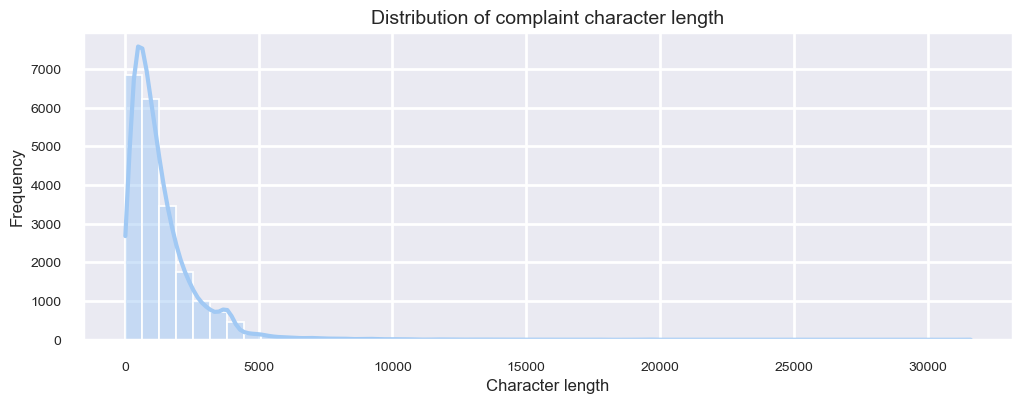

In [355]:
# Write your code here to visualise the data according to the 'Complaint' character length
df_clean['complaint_length'] = df_clean['complaint'].str.len()

sns.histplot(df_clean['complaint_length'], bins=50, kde=True)
plt.title('Distribution of complaint character length')
plt.xlabel('Character length')
plt.ylabel('Frequency')
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

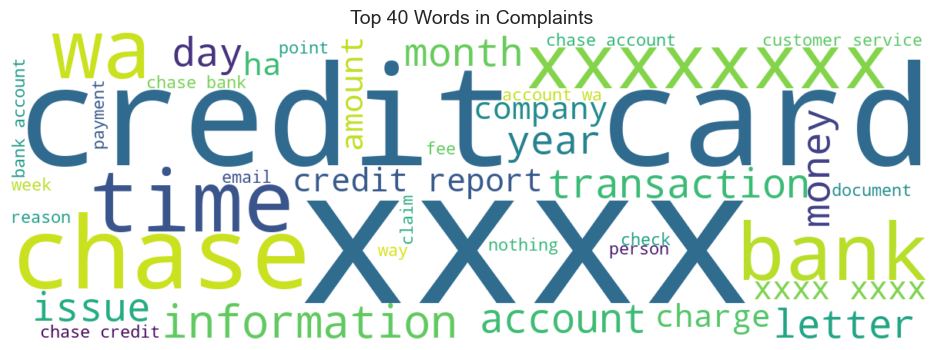

In [356]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud

all_text = ' '.join(df_clean['complaint_POS_removed'].dropna())

wordcloud = WordCloud(width=1200, height=400, max_words=40, background_color='white').generate(all_text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Top 40 Words in Complaints")
plt.show()

In [357]:
#Removing -PRON- from the text corpus
df_clean['complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [ ]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_uni = CountVectorizer(ngram_range=(1,1), stop_words='english', max_features=10000)
X_uni = vectorizer_uni.fit_transform(df_clean['complaint_clean'].dropna())

unigram_freq = pd.DataFrame(X_uni.toarray(), columns=vectorizer_uni.get_feature_names_out()).sum()

In [359]:
#Print the top 10 words in the unigram frequency
unigram_freq.head(10)

aa               5
aacount          1
aaid             1
aarp            16
ab               2
aba              1
abandonment      2
abatement        6
abbreviation     2
abc              1
dtype: int64

In [362]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
vectorizer_bi = CountVectorizer(ngram_range=(2,2), stop_words='english', max_features=10000)
X_bi = vectorizer_bi.fit_transform(df_clean['complaint_clean'].dropna())

bigram_freq = pd.DataFrame(X_bi.toarray(), columns=vectorizer_bi.get_feature_names_out()).sum()

In [363]:
#Print the top 10 words in the bigram frequency
bigram_freq.head(10)

ability account     25
ability credit      40
ability loan        26
ability payment     20
access access       15
access account     491
access bank         61
access banking      16
access card         42
access chase        44
dtype: int64

In [364]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
vectorizer_tri = CountVectorizer(ngram_range=(3,3), stop_words='english', max_features=10000)
X_tri = vectorizer_tri.fit_transform(df_clean['complaint_clean'].dropna())

trigram_freq = pd.DataFrame(X_tri.toarray(), columns=vectorizer_tri.get_feature_names_out()).sum()

In [365]:
#Print the top 10 words in the trigram frequency
trigram_freq.head(10)

ability consumer information    10
ability credit card              8
ability loan application        13
access account access           10
access account account          28
access account bank             10
access account charge           12
access account chase            29
access account information      14
access account money            11
dtype: int64

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [366]:
df_clean['complaint_clean'] = df_clean['complaint_clean'].str.replace('xxxx','')

In [367]:
#All masked texts has been removed
df_clean.head(2)

,complaint,cleaned_complaint,lemmatized_complaint,complaint_POS_removed,complaint_length,complaint_clean
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,"[good, morning, my, name, is, xxxx, xxxx, and, i, appreciate, it, if, you, could, help, me, put, a, stop, to, chase, bank, cardmember, service, in, i, wrote, to, chase, asking, for, debt, verification, and, what, they, sent, me, a, statement, which, is, not, acceptable, i, am, asking, the, bank, to, validate, the, debt, instead, i, been, receiving, mail, every, month, from, them, attempting, to, collect, a, debt, i, have, a, right, to, know, this, information, a, a, consumer, chase, account, xxxx, xxxx, xxxx, xxxx, thanks, in, advance, for, your, help]",morning name stop bank cardmember service debt verification statement i bank debt mail month debt i right information consumer chase account advance help,486,morning name stop bank cardmember service debt verification statement i bank debt mail month debt i right information consumer chase account advance help
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,"[i, upgraded, my, xxxx, xxxx, card, in, and, wa, told, by, the, agent, who, did, the, upgrade, my, anniversary, date, would, not, change, it, turned, the, agent, wa, giving, me, the, wrong, information, in, order, to, upgrade, the, account, xxxx, changed, my, anniversary, date, from, xxxxxxxx, to, xxxxxxxx, without, my, consent, xxxx, ha, the, recording, of, the, agent, who, wa, misled, me]",i card agent upgrade date agent wa information order account date xxxxxxxx consent xxxx recording agent,355,i card agent upgrade date agent wa information order account date consent recording agent


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [368]:
#Write your code here to initialise the TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [369]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf_vectorizer.fit_transform(df_clean['complaint_clean'].dropna())

print(tfidf_vectorizer.get_feature_names_out())
print(dtm.shape) # Complaints (or documents), Features
print(dtm[0]) # For the first complaint, we can see the featurea and their TF-IDF score.

['aa' 'aarp' 'ab' ... 'zipcode' 'zombie' 'zone']
(21072, 6969)
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 17 stored elements and shape (1, 6969)>
  Coords	Values
  (0, 4109)	0.2366507461517706
  (0, 6003)	0.3335900276710979
  (0, 531)	0.18495874720425798
  (0, 899)	0.32629636133338574
  (0, 5653)	0.13806245085692656
  (0, 1692)	0.5637125766718298
  (0, 6674)	0.2579662346059314
  (0, 5953)	0.16035452363613512
  (0, 3808)	0.18314939103931407
  (0, 4094)	0.13015626087508136
  (0, 5413)	0.2120592283338555
  (0, 3277)	0.1301027361821566
  (0, 1396)	0.18191791715665215
  (0, 1033)	0.07138618803093881
  (0, 41)	0.08111004467879253
  (0, 128)	0.26462351524276156
  (0, 2976)	0.18912179344897995


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [370]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [371]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40) #write your code here

In [372]:
nmf_model.fit(dtm)
print(len(tfidf_vectorizer.get_feature_names_out()))
print(len(nmf_model.components_))

6969
5


In [373]:
#Print the Top15 words for each of the topics
words = tfidf_vectorizer.get_feature_names_out()
top_n_words = 15

for i, topic in enumerate(nmf_model.components_):
    print(f"Topic #{i+1}:")
    print(" | ".join([words[i] for i in topic.argsort()[-1 * top_n_words:][::-1]]))

Topic #1:
account | bank | check | money | chase | fund | wa | deposit | branch | day | transaction | number | business | checking | claim
Topic #2:
card | charge | chase | credit | wa | dispute | transaction | purchase | fraud | merchant | service | fee | time | claim | company
Topic #3:
payment | balance | fee | month | statement | wa | day | time | date | auto | credit | chase | account | year | error
Topic #4:
credit | report | inquiry | card | account | score | bureau | company | debt | reporting | information | limit | application | chase | identity
Topic #5:
loan | mortgage | chase | home | modification | property | year | wa | letter | rate | time | document | foreclosure | bank | house


In [374]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_result = nmf_model.transform(dtm)

In [375]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['topic'] = topic_result.argmax(axis=1) #write your code to assign topics to each rows.

In [376]:
df_clean.head(2)

,complaint,cleaned_complaint,lemmatized_complaint,complaint_POS_removed,complaint_length,complaint_clean,topic
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,"[good, morning, my, name, is, xxxx, xxxx, and, i, appreciate, it, if, you, could, help, me, put, a, stop, to, chase, bank, cardmember, service, in, i, wrote, to, chase, asking, for, debt, verification, and, what, they, sent, me, a, statement, which, is, not, acceptable, i, am, asking, the, bank, to, validate, the, debt, instead, i, been, receiving, mail, every, month, from, them, attempting, to, collect, a, debt, i, have, a, right, to, know, this, information, a, a, consumer, chase, account, xxxx, xxxx, xxxx, xxxx, thanks, in, advance, for, your, help]",morning name stop bank cardmember service debt verification statement i bank debt mail month debt i right information consumer chase account advance help,486,morning name stop bank cardmember service debt verification statement i bank debt mail month debt i right information consumer chase account advance help,0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,"[i, upgraded, my, xxxx, xxxx, card, in, and, wa, told, by, the, agent, who, did, the, upgrade, my, anniversary, date, would, not, change, it, turned, the, agent, wa, giving, me, the, wrong, information, in, order, to, upgrade, the, account, xxxx, changed, my, anniversary, date, from, xxxxxxxx, to, xxxxxxxx, without, my, consent, xxxx, ha, the, recording, of, the, agent, who, wa, misled, me]",i card agent upgrade date agent wa information order account date xxxxxxxx consent xxxx recording agent,355,i card agent upgrade date agent wa information order account date consent recording agent,1


In [377]:
#Print the first 5 Complaint for each of the Topics
df_clean=df_clean.groupby('topic').head(1)
df_clean.sort_values('topic')

,complaint,cleaned_complaint,lemmatized_complaint,complaint_POS_removed,complaint_length,complaint_clean,topic
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,"[good, morning, my, name, is, xxxx, xxxx, and, i, appreciate, it, if, you, could, help, me, put, a, stop, to, chase, bank, cardmember, service, in, i, wrote, to, chase, asking, for, debt, verification, and, what, they, sent, me, a, statement, which, is, not, acceptable, i, am, asking, the, bank, to, validate, the, debt, instead, i, been, receiving, mail, every, month, from, them, attempting, to, collect, a, debt, i, have, a, right, to, know, this, information, a, a, consumer, chase, account, xxxx, xxxx, xxxx, xxxx, thanks, in, advance, for, your, help]",morning name stop bank cardmember service debt verification statement i bank debt mail month debt i right information consumer chase account advance help,486,morning name stop bank cardmember service debt verification statement i bank debt mail month debt i right information consumer chase account advance help,0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,"[i, upgraded, my, xxxx, xxxx, card, in, and, wa, told, by, the, agent, who, did, the, upgrade, my, anniversary, date, would, not, change, it, turned, the, agent, wa, giving, me, the, wrong, information, in, order, to, upgrade, the, account, xxxx, changed, my, anniversary, date, from, xxxxxxxx, to, xxxxxxxx, without, my, consent, xxxx, ha, the, recording, of, the, agent, who, wa, misled, me]",i card agent upgrade date agent wa information order account date xxxxxxxx consent xxxx recording agent,355,i card agent upgrade date agent wa information order account date consent recording agent,1
20,"During the summer months, I experience a decline income due to my employment. Therefore, I request a one month payment extension with my Auto Loan Company, Chase. For the past almost fours years, my request for payment extension is granted. I have never been delinquent with my auto loan payment. However, On XX/XX/2019 my request for a one month payment extension was denied this year. I explained my situation to representative and the supervisor with no avail. After a lengthy discussion and waiting, I was informed the reason for the decline as it is not "" contractual ''. This reason for denial baffled me and therefore I emailed the office of XXXX XXXX Executive Director, Communications, JPMorgan Chase & Co. A representative contacted me and s

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [378]:
#Create the dictionary of Topic names and Topics

Topic_names = {
    0:'Account services',
    1:'Credit card', 
    2:'Payments',
    3:'Disputes',
    4:'Collection' 
    }

#Replace Topics with Topic Names
df_clean['topic'] = df_clean['topic'].map(Topic_names)

In [379]:
df_clean.head(1)

,complaint,cleaned_complaint,lemmatized_complaint,complaint_POS_removed,complaint_length,complaint_clean,topic
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,"[good, morning, my, name, is, xxxx, xxxx, and, i, appreciate, it, if, you, could, help, me, put, a, stop, to, chase, bank, cardmember, service, in, i, wrote, to, chase, asking, for, debt, verification, and, what, they, sent, me, a, statement, which, is, not, acceptable, i, am, asking, the, bank, to, validate, the, debt, instead, i, been, receiving, mail, every, month, from, them, attempting, to, collect, a, debt, i, have, a, right, to, know, this, information, a, a, consumer, chase, account, xxxx, xxxx, xxxx, xxxx, thanks, in, advance, for, your, help]",morning name stop bank cardmember service debt verification statement i bank debt mail month debt i right information consumer chase account advance help,486,morning name stop bank cardmember service debt verification statement i bank debt mail month debt i right information consumer chase account advance help,Account services


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [380]:
#Create the dictionary again of Topic names and Topics

Topic_names = {
    'Account services': 0,
    'Credit card': 1, 
    'Payments': 2,
    'Disputes': 3,
    'Collection': 4 
    }
#Replace Topics with Topic Names
df_clean['topic'] = df_clean['topic'].map(Topic_names)

In [381]:
df_clean.head(1)

,complaint,cleaned_complaint,lemmatized_complaint,complaint_POS_removed,complaint_length,complaint_clean,topic
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,"[good, morning, my, name, is, xxxx, xxxx, and, i, appreciate, it, if, you, could, help, me, put, a, stop, to, chase, bank, cardmember, service, in, i, wrote, to, chase, asking, for, debt, verification, and, what, they, sent, me, a, statement, which, is, not, acceptable, i, am, asking, the, bank, to, validate, the, debt, instead, i, been, receiving, mail, every, month, from, them, attempting, to, collect, a, debt, i, have, a, right, to, know, this, information, a, a, consumer, chase, account, xxxx, xxxx, xxxx, xxxx, thanks, in, advance, for, your, help]",morning name stop bank cardmember service debt verification statement i bank debt mail month debt i right information consumer chase account advance help,486,morning name stop bank cardmember service debt verification statement i bank debt mail month debt i right information consumer chase account advance help,0


In [382]:
df_clean.columns

Index(['complaint', 'cleaned_complaint', 'lemmatized_complaint',
       'complaint_POS_removed', 'complaint_length', 'complaint_clean',
       'topic'],
      dtype='object')

In [383]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[['complaint','topic']]

In [384]:
training_data.head()

,complaint,topic
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,1
10,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",3
20,"During the summer months, I experience a decline income due to my employment. Therefore, I request a one month payment extension with my Auto Loan Company, Chase. For the past almost fours years, my request for payment extension is granted. I have never been delinquent with my auto loan payment. However, On XX/XX/2019 my request for a one month payment extension was denied this year. I explained my situation to representative and the supervisor with no avail. After a lengthy discussion and waiting, I was informed the reason for the decline as it is not "" contractual ''. This reason for denial baffled me and therefore I emailed the office of XXXX XXXX Executive Director, Communications, JPMorgan Chase & Co. A representative contacted me and stated Chase will follow-up. About week later a representative of XXXX XXXX XXXX XXXX office called. The representative shared her role was help resolve the matter. The representative via conference call contacted the department handing my request. After, reviewing my information my request was still denied based on "" policy changes ''. I requested an explanation and representative stated a letter will be mailed with explanation. I have received XXXX letters the reason for denial was not "" policy changes ''. I would like CFPB help in exploring the denial of my payment extension request especially since I have been clear reason for denial.",2
48,"JP Morgan Chase Bank, please answer the following questions : 1. ) On XX/XX/XXXX, XX/XX/XXXX,XX/XX/XXXX, XX/XX/XXXX & XX/XX/XXXX, JPMorgan Chase accessed information about me through XXXX XXXX XXXX , XXXX. \n*What was the valid reason for accessing my personal information through XXXX XXXX XXXX , XXXX? \n\n2. ) The Chase Checking Account that was closed recently during XX/XX/XXXX had a routing or XXXX number of XXXX, according to checks and statements provided to me by Chase. \nXXXX XXXX XXXX showed Chase reporting an XXXX routing number of XXXX, before and after I had disputed the XXXX number with Chase. \n*Why do these two routing numbers not match? \n\n3. ) XX/XX/XXXX, I received a response, from XXXX XXXX XXXX XXXX, to a dispute about information Chase was providing on my report. Dispute case ID XXXX The information Chase had been submitting was deleted due to disputed info being incomplete, inaccurate or unverifiable. \n*Is this true? \n\nOnce again, I have asked 3. ) * questions. \n\nI will send the CFPB copies of the information I have pertaining to the 3 questions in this complaint, via US Mail, which are the XXXX XXXX XXXX, XXXX reports I've received. \n\nThank you for your attention and humbly await your response,",4


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [385]:
from sklearn.model_selection import train_test_split

#Write your code to get the Vector count
vector_count = CountVectorizer()

#Write your code here to transform the word vector to tf-idf
X_train_count = vector_count.fit_transform(training_data['complaint'])

tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_train_count)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [386]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, 
    training_data['topic'], 
    test_size=0.3, 
    random_state=42
)

In [387]:
# Write your code here to build any 3 models and evaluate them using the required metrics
# Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

print("Logistic Regression Performance:")
print("Accuracy:", accuracy_score(y_test, lr_preds))
print(classification_report(y_test, lr_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, lr_preds))

Logistic Regression Performance:
Accuracy: 0.0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00       1.0
           3       0.00      0.00      0.00       0.0
           4       0.00      0.00      0.00       1.0

    accuracy                           0.00       2.0
   macro avg       0.00      0.00      0.00       2.0
weighted avg       0.00      0.00      0.00       2.0

Confusion Matrix:
 [[0 0 0 0]
 [0 0 1 0]
 [0 0 0 0]
 [1 0 0 0]]


In [388]:
# Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_preds = dt_model.predict(X_test)

print("Decision Tree Performance:")
print("Accuracy:", accuracy_score(y_test, dt_preds))
print(classification_report(y_test, dt_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, dt_preds))

Decision Tree Performance:
Accuracy: 0.0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00       1.0
           3       0.00      0.00      0.00       0.0
           4       0.00      0.00      0.00       1.0

    accuracy                           0.00       2.0
   macro avg       0.00      0.00      0.00       2.0
weighted avg       0.00      0.00      0.00       2.0

Confusion Matrix:
 [[0 0 0 0]
 [0 0 1 0]
 [0 0 0 0]
 [1 0 0 0]]


In [389]:
# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

print("Random Forest Performance:")
print("Accuracy:", accuracy_score(y_test, rf_preds))
print(classification_report(y_test, rf_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_preds))

Random Forest Performance:
Accuracy: 0.0
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       1.0
           3       0.00      0.00      0.00       0.0
           4       0.00      0.00      0.00       1.0

    accuracy                           0.00       2.0
   macro avg       0.00      0.00      0.00       2.0
weighted avg       0.00      0.00      0.00       2.0

Confusion Matrix:
 [[0 1 0]
 [0 0 0]
 [0 1 0]]
